# Hessian矩阵计算与特征值计算

本notebook实现两个主要步骤：
1. 计算训练好的MLP模型的Hessian矩阵
2. 计算Hessian矩阵的特征值

In [1]:
import torch
import torch.nn as nn
import numpy as np
import time
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import os
import matplotlib.pyplot as plt

# 设置随机种子
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)
np.random.seed(0)

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. 定义MLP模型

In [2]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size, bias=False)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size, bias=False)
        
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

## 2. 加载数据集

In [3]:
# 数据预处理
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # MNIST的均值和标准差
])

# 加载数据集
kwargs = {'num_workers': 4, 'pin_memory': True}
try:
    # 尝试使用用户本地路径
    data_path = os.path.join(os.getcwd(), 'data')
    train_dataset = datasets.MNIST(root=data_path, train=True, transform=transform, download=True)
except Exception as e:
    print(f"加载数据出错: {e}")
    print("尝试使用默认路径...")
    train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)

# 创建数据加载器
train_loader = DataLoader(dataset=train_dataset, batch_size=60000, shuffle=False, **kwargs)

# 模型参数
input_size = 784  # 28x28
hidden_size = 5
output_size = 10  # 0-9的数字

## 3. 加载预训练模型

In [4]:
# 创建模型
model = MLP(input_size, hidden_size, output_size)

# 训练运行目录（包含 ckpts 子目录）
script_dir = os.getcwd()
ckpt_dir = "bs256_lr0.05_e30_hidden5_SGD_m0.9_wsd3.0_seed0_resume_28.000_decay_3"  # 训练目录名
ckpts_root = f"{script_dir}/trained_MLP/{ckpt_dir}/ckpts"

# 如果只想跑单个 ckpt，填写其绝对路径；否则留空使用多ckpt流程
single_ckpt_path = None  # e.g. f"{ckpts_root}/epoch_0.050_step_000011_wsd/ckpt.pt"

# 尝试加载（仅当指定了 single_ckpt_path 时）
if single_ckpt_path:
    print("尝试加载单个预训练模型...")
    try:
        state_dict = torch.load(single_ckpt_path, map_location=torch.device('cpu'))
        model.load_state_dict(state_dict['state_dict'])
        print(f"成功加载模型: {single_ckpt_path}")
    except Exception as e:
        print(f"加载模型失败: {e}")
        print("使用随机初始化的模型继续...")

# 将模型移至GPU
model = model.cuda()
criterion = nn.CrossEntropyLoss()

## 4. 定义Hessian计算函数

In [5]:
def compute_hessian(dataloader, model, criterion):
    """
    计算模型在给定数据集上的Hessian矩阵
    
    参数:
    - dataloader: 数据加载器
    - model: 神经网络模型
    - criterion: 损失函数
    
    返回:
    - hessian: Hessian矩阵
    - gradient: 梯度向量
    """
    print("Step 1: 开始计算Hessian矩阵...")
    start_time = time.time()
    
    model.eval()
    model.zero_grad(set_to_none=True)
    
    # 内部函数：计算Hessian矩阵的一行
    def compute_hessian_row(g_tensor):
        g_tensor = g_tensor.cuda()
        total_params = g_tensor.size(0)
        hessian_list = []
        
        for d in range(total_params):
            # 创建单位向量
            unit_vector = torch.zeros(total_params)
            unit_vector[d] = 1
            unit_vector = unit_vector.cuda()
            
            # 计算梯度的方向导数
            l = torch.sum(g_tensor * unit_vector)
            l.backward(retain_graph=True)
            
            # 收集Hessian的一行
            hessian_row = []
            for name, param in model.named_parameters():
                if 'ln' in name or 'bias' in name or 'wte' in name or 'wpe' in name:
                    continue
                if param.requires_grad:
                    hessian_row.append(param.grad.double().data.clone())
            
            model.zero_grad(set_to_none=True)
            hessian_row = [g.flatten() for g in hessian_row]
            hessian_row = [g.cpu() for g in hessian_row]
            hessian_row = torch.cat(hessian_row)
            
            hessian_list.append(hessian_row)
            
            # 打印进度
            if d % 500 == 0 and d > 0:
                print(f"  计算Hessian: 已完成 {d}/{total_params} 行, 用时 {time.time() - start_time:.2f}秒")
                
        hessian = torch.stack(hessian_list, dim=1)
        return hessian
    
    # 计算完整的Hessian矩阵
    full_hessian = 0
    for images, labels in dataloader:
        labels = labels.cuda()
        images = images.reshape(-1, 28 * 28).cuda()
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # 缩放损失并计算梯度
        scaled_loss = loss / len(dataloader)
        scaled_loss.backward(create_graph=True)
        
        # 收集梯度
        g_list = []
        for name, param in model.named_parameters():
            if 'ln' in name or 'bias' in name or 'wte' in name or 'wpe' in name:
                continue
            if param.requires_grad:
                g_list.append(torch.flatten(param.grad.double()))
        
        g_tensor = torch.cat(g_list, dim=0)
        model.zero_grad(set_to_none=True)
        
        # 计算Hessian矩阵
        H = compute_hessian_row(g_tensor)
        full_hessian += H
    
    # 处理数值问题
    full_hessian = torch.nan_to_num(full_hessian, nan=0, posinf=0, neginf=0)
    
    # 确保Hessian矩阵是对称的
    full_hessian = full_hessian.numpy().astype(np.float64)
    full_hessian = (full_hessian + full_hessian.T) / 2
    
    print(f"Hessian矩阵计算完成，用时 {time.time() - start_time:.2f}秒")
    return full_hessian, g_tensor

## 5. 使用 torch.linalg.eigh 计算特征值并保存

In [6]:
def compute_eigenvalues_eigh(hessian, output_dir: str = "hessian_results", prefix: str = "hessian"):
    """
    使用对称特征值分解 (torch.linalg.eigh) 计算Hessian矩阵的特征值与特征向量，并将全部特征值保存到磁盘。

    参数:
    - hessian: 对称 Hessian 矩阵 (numpy 数组或 torch 张量)
    - output_dir: 保存结果的目录
    - prefix: 输出文件名前缀

    返回:
    - eigenvalues: 特征值 (torch.Tensor, 升序)
    - eigenvectors: 特征向量 (torch.Tensor)
    """
    print("\nStep 2: 开始通过 torch.linalg.eigh 计算特征值...")
    start_time = time.time()

    # 转为张量并移至 GPU
    if not torch.is_tensor(hessian):
        hessian_tensor = torch.tensor(hessian)
    else:
        hessian_tensor = hessian
    hessian_tensor = hessian_tensor.cuda()

    # eigh 适用于对称矩阵，返回升序特征值
    eigenvalues, eigenvectors = torch.linalg.eigh(hessian_tensor)

    elapsed = time.time() - start_time
    print(f"eigh 分解完成，用时 {elapsed:.2f}秒")
    print(f"特征值形状: {eigenvalues.shape}")

    # 打印前10个特征值（可能包含负值）
    print("\n前10个特征值:")
    for i, val in enumerate(eigenvalues[:10]):
        print(f"  λ_{i+1} = {val.item():.6f}")

    # 保存全部特征值
    os.makedirs(output_dir, exist_ok=True)
    timestamp = time.strftime("%Y%m%d_%H%M%S")
    ev_path = os.path.join(output_dir, f"{prefix}_eigenvalues_{timestamp}.npy")
    np.save(ev_path, eigenvalues.detach().cpu().numpy())
    print(f"已保存所有特征值到: {ev_path}")

    return eigenvalues, eigenvectors

## 6. 执行Hessian计算和特征值

In [7]:
# 计算Hessian矩阵（仅当指定了 single_ckpt_path 时运行单次）
if single_ckpt_path:
    hessian, gradient = compute_hessian(train_loader, model, criterion)
else:
    print("跳过单次计算：未设置 single_ckpt_path，将使用多 ckpt 流程")
    hessian, gradient = None, None

跳过单次计算：未设置 single_ckpt_path，将使用多 ckpt 流程


In [8]:
# 计算特征值（升序），并将所有特征值保存到磁盘（仅单次流程）
if hessian is not None:
    eigenvalues, eigenvectors = compute_eigenvalues_eigh(hessian, output_dir="hessian_results", prefix="mnist_mlp")
else:
    eigenvalues, eigenvectors = None, None

In [9]:
# 多 ckpt 批量计算：遍历 `ckpts` 目录中所有 `epoch_*_wsd/ckpt.pt`
import re
from glob import glob


def list_ckpt_paths(ckpts_root_dir: str) -> list:
    """返回按 epoch 数值排序的 ckpt.pt 路径列表。
    目录名形如: epoch_0.050_step_000011_wsd
    文件名: ckpt.pt
    """
    if not os.path.isdir(ckpts_root_dir):
        print(f"未找到 ckpts 目录: {ckpts_root_dir}")
        return []
    pattern = os.path.join(ckpts_root_dir, "epoch_*_wsd", "ckpt.pt")
    paths = glob(pattern)

    def extract_epoch(p: str) -> float:
        m = re.search(r"epoch_(\d+\.\d+)_step_\d+", p)
        if m:
            return float(m.group(1))
        # 兜底：未匹配时放到末尾
        return float('inf')

    paths.sort(key=extract_epoch)
    return paths


def compute_hessian_spectrum_for_ckpt(ckpt_path: str) -> dict:
    """加载 ckpt 到当前 `model`，计算 Hessian 及其特征值（升序）。"""
    tmp_model = MLP(input_size, hidden_size, output_size).cuda()
    try:
        state_dict = torch.load(ckpt_path, map_location=torch.device('cpu'))
        tmp_model.load_state_dict(state_dict['state_dict'])
    except Exception as e:
        print(f"加载失败，跳过: {ckpt_path} | {e}")
        return {}

    H, g = compute_hessian(train_loader, tmp_model, criterion)
    evals, evecs = compute_eigenvalues_eigh(H, output_dir="hessian_results", prefix="mnist_mlp")
    # 返回关键信息：最大/最小/trace/norm
    evals_cpu = evals.detach().cpu().numpy()
    return {
        "ckpt": ckpt_path,
        "num_params": len(g),
        "lambda_min": float(evals_cpu[0]),
        "lambda_max": float(evals_cpu[-1]),
        "trace": float(evals_cpu.sum()),
        "l2_norm": float(np.linalg.norm(evals_cpu)),
        "all_evals": evals_cpu,
    }


ckpt_paths = list_ckpt_paths(ckpts_root)
print(f"发现 {len(ckpt_paths)} 个 ckpt: \n" + "\n".join(ckpt_paths[:5] + (["..."] if len(ckpt_paths) > 5 else [])))


发现 63 个 ckpt: 
/zhanglimeng/compute_hessian/trained_MLP/bs256_lr0.05_e30_hidden5_SGD_m0.9_wsd3.0_seed0_resume_28.000_decay_3/ckpts/epoch_27.050_step_000011_wsd/ckpt.pt
/zhanglimeng/compute_hessian/trained_MLP/bs256_lr0.05_e30_hidden5_SGD_m0.9_wsd3.0_seed0_resume_28.000_decay_3/ckpts/epoch_27.100_step_000022_wsd/ckpt.pt
/zhanglimeng/compute_hessian/trained_MLP/bs256_lr0.05_e30_hidden5_SGD_m0.9_wsd3.0_seed0_resume_28.000_decay_3/ckpts/epoch_27.150_step_000033_wsd/ckpt.pt
/zhanglimeng/compute_hessian/trained_MLP/bs256_lr0.05_e30_hidden5_SGD_m0.9_wsd3.0_seed0_resume_28.000_decay_3/ckpts/epoch_27.200_step_000044_wsd/ckpt.pt
/zhanglimeng/compute_hessian/trained_MLP/bs256_lr0.05_e30_hidden5_SGD_m0.9_wsd3.0_seed0_resume_28.000_decay_3/ckpts/epoch_27.250_step_000055_wsd/ckpt.pt
...


In [10]:
# 顺序遍历所有 ckpt，收集 Hessian 统计量并保存
results = []
for p in ckpt_paths:
    out = compute_hessian_spectrum_for_ckpt(p)
    if out:
        results.append(out)

# 保存为 npy/csv，方便之后画趋势图
os.makedirs("hessian_results", exist_ok=True)
np.save("hessian_results/hessian_trend.npy", results, allow_pickle=True)

import csv
csv_path = "hessian_results/hessian_trend.csv"
with open(csv_path, "w", newline="") as f:
    writer = csv.DictWriter(
        f,
        fieldnames=["ckpt", "num_params", "lambda_min", "lambda_max", "trace", "l2_norm"],
    )
    writer.writeheader()
    for r in results:
        writer.writerow({k: r[k] for k in writer.fieldnames})

print(f"已保存趋势结果到: {csv_path}")


Step 1: 开始计算Hessian矩阵...


/usr/local/lib/python3.10/dist-packages/torch/autograd/__init__.py:266: UserWarning: Using backward() with create_graph=True will create a reference cycle between the parameter and its gradient which can cause a memory leak. We recommend using autograd.grad when creating the graph to avoid this. If you have to use this function, make sure to reset the .grad fields of your parameters to None after use to break the cycle and avoid the leak. (Triggered internally at ../torch/csrc/autograd/engine.cpp:1177.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


  计算Hessian: 已完成 500/3970 行, 用时 9.51秒
  计算Hessian: 已完成 1000/3970 行, 用时 9.99秒
  计算Hessian: 已完成 1500/3970 行, 用时 10.48秒
  计算Hessian: 已完成 2000/3970 行, 用时 10.96秒
  计算Hessian: 已完成 2500/3970 行, 用时 11.45秒
  计算Hessian: 已完成 3000/3970 行, 用时 11.94秒
  计算Hessian: 已完成 3500/3970 行, 用时 12.42秒
Hessian矩阵计算完成，用时 13.17秒

Step 2: 开始通过 torch.linalg.eigh 计算特征值...
eigh 分解完成，用时 0.27秒
特征值形状: torch.Size([3970])

前10个特征值:
  λ_1 = -0.217454
  λ_2 = -0.099796
  λ_3 = -0.083510
  λ_4 = -0.053657
  λ_5 = -0.024815
  λ_6 = -0.022909
  λ_7 = -0.015252
  λ_8 = -0.010601
  λ_9 = -0.006859
  λ_10 = -0.005741
已保存所有特征值到: hessian_results/mnist_mlp_eigenvalues_20250815_084222.npy
Step 1: 开始计算Hessian矩阵...
  计算Hessian: 已完成 500/3970 行, 用时 9.52秒
  计算Hessian: 已完成 1000/3970 行, 用时 10.03秒
  计算Hessian: 已完成 1500/3970 行, 用时 10.55秒
  计算Hessian: 已完成 2000/3970 行, 用时 11.07秒
  计算Hessian: 已完成 2500/3970 行, 用时 11.59秒
  计算Hessian: 已完成 3000/3970 行, 用时 12.09秒
  计算Hessian: 已完成 3500/3970 行, 用时 12.60秒
Hessian矩阵计算完成，用时 13.38秒

Step 2: 开始通过 torch.linalg

In [ ]:
# 可视化多 ckpt 的 Hessian 指标趋势
# 从路径中解析 epoch，按 epoch 画曲线

def parse_epoch_from_path(p: str) -> float:
    m = re.search(r"epoch_(\d+\.\d+)_step_\d+", p)
    return float(m.group(1)) if m else float('nan')

if results:
    epochs = [parse_epoch_from_path(r["ckpt"]) for r in results]
    lambda_max = [r["lambda_max"] for r in results]
    lambda_min = [r["lambda_min"] for r in results]
    trace_vals = [r["trace"] for r in results]
    l2_norms = [r["l2_norm"] for r in results]

    plt.figure(figsize=(12, 8))
    plt.subplot(2, 2, 1)
    plt.plot(epochs, lambda_max, 'o-')
    plt.title('lambda_max vs epoch')
    plt.xlabel('epoch')
    plt.ylabel('lambda_max')

    plt.subplot(2, 2, 2)
    plt.plot(epochs, lambda_min, 'o-')
    plt.title('lambda_min vs epoch')
    plt.xlabel('epoch')
    plt.ylabel('lambda_min')

    plt.subplot(2, 2, 3)
    plt.plot(epochs, trace_vals, 'o-')
    plt.title('trace(H) vs epoch')
    plt.xlabel('epoch')
    plt.ylabel('trace')

    plt.subplot(2, 2, 4)
    plt.plot(epochs, l2_norms, 'o-')
    plt.title('||eigs||_2 vs epoch')
    plt.xlabel('epoch')
    plt.ylabel('L2 norm')

    plt.tight_layout()
    plt.show()
else:
    print("没有可视化的数据：results 为空")


## 7. 可视化结果

In [ ]:
# 可视化特征值分布（仅单次流程）
if eigenvalues is not None:
    plt.figure(figsize=(10, 6))
    eigenvalues_cpu = eigenvalues.detach().cpu().numpy()
    plt.semilogy(range(1, len(eigenvalues_cpu) + 1), np.abs(eigenvalues_cpu), 'bo-', label='|eigenvalues|')
    plt.title('Hessian矩阵特征值分布 (对数尺度，取绝对值)')
    plt.xlabel('特征值索引')
    plt.ylabel('特征值大小 (对数尺度)')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("跳过单次特征值分布可视化")

In [ ]:
# 可视化前100个特征值（仅单次流程）
if eigenvalues is not None:
    plt.figure(figsize=(10, 6))
    top_n = 100
    eigenvalues_cpu = eigenvalues.detach().cpu().numpy()
    plt.plot(range(1, min(top_n, len(eigenvalues_cpu)) + 1), eigenvalues_cpu[:top_n], 'go-', label='eigenvalues')
    plt.title(f'Hessian矩阵前{top_n}个特征值')
    plt.xlabel('特征值索引')
    plt.ylabel('特征值大小')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("跳过单次前100个特征值可视化")

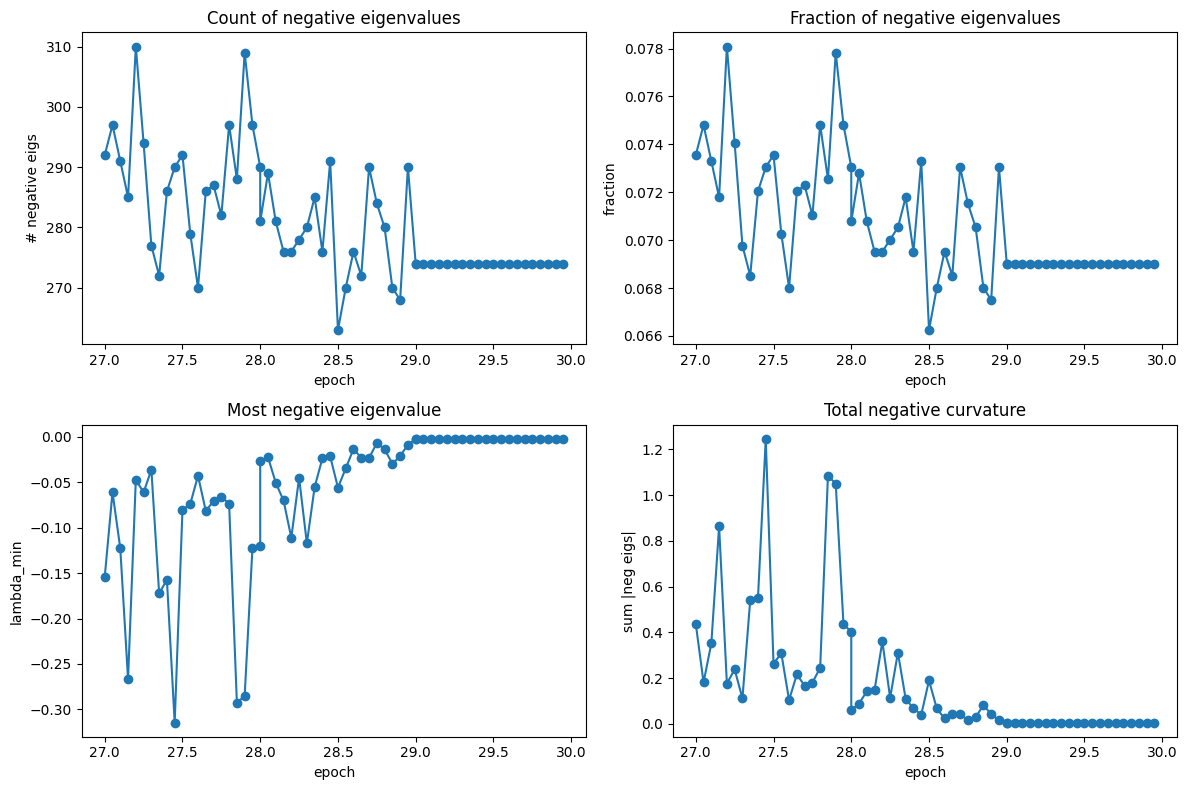

In [3]:
import os, re, csv, torch
import numpy as np
import matplotlib.pyplot as plt

def parse_resume_base_from_run_dir(run_dir: str) -> float:
    m = re.search(r"resume_([0-9.]+)_decay_", run_dir)
    return float(m.group(1)) if m else float("nan")

def epoch_from_ckpt(ckpt_path: str) -> float:
    st = torch.load(ckpt_path, map_location="cpu")
    return float(st.get("epoch_progress", np.nan))

# 载入已保存的结果
npy_path = "trained_MLP/bs256_lr0.05_e30_hidden5_SGD_m0.9_wsd3.0_seed0_resume_27.000_decay_3/hessian_results/hessian_trend.npy"
loaded = np.load(npy_path, allow_pickle=True).tolist()
results = loaded if isinstance(loaded, list) else list(loaded)

# 先用 ckpt 内部的 epoch_progress 作为横轴
epochs = [epoch_from_ckpt(r["ckpt"]) for r in results]
epochs = np.array(epochs, dtype=float)

# 从 run 目录名解析真实起点，并进行对齐（平移）
run_dir = os.path.dirname(os.path.dirname(npy_path))  # .../run_dir/hessian_results/hessian_trend.npy
resume_base = parse_resume_base_from_run_dir(run_dir)
if not np.isnan(resume_base) and np.isfinite(resume_base) and len(epochs) > 0:
    min_ep = np.nanmin(epochs)
    if np.isfinite(min_ep):
        shift = resume_base - min_ep
        epochs = epochs + shift

# 统计负特征值指标
neg_count, neg_frac, lambda_min, sum_abs_neg = [], [], [], []
for r in results:
    evals = np.asarray(r["all_evals"])
    neg = evals[evals < 0]
    neg_count.append(int(neg.size))
    neg_frac.append(float(neg.size) / float(evals.size))
    lambda_min.append(float(evals.min()))
    sum_abs_neg.append(float(np.abs(neg).sum()) if neg.size else 0.0)

order = np.argsort(epochs)
ep = epochs[order]

plt.figure(figsize=(12,8))
plt.subplot(2,2,1); plt.plot(ep, np.array(neg_count)[order], "o-"); plt.xlabel("epoch"); plt.ylabel("# negative eigs"); plt.title("Count of negative eigenvalues")
plt.subplot(2,2,2); plt.plot(ep, np.array(neg_frac)[order], "o-");  plt.xlabel("epoch"); plt.ylabel("fraction");      plt.title("Fraction of negative eigenvalues")
plt.subplot(2,2,3); plt.plot(ep, np.array(lambda_min)[order], "o-"); plt.xlabel("epoch"); plt.ylabel("lambda_min");    plt.title("Most negative eigenvalue")
plt.subplot(2,2,4); plt.plot(ep, np.array(sum_abs_neg)[order], "o-");plt.xlabel("epoch"); plt.ylabel("sum |neg eigs|");plt.title("Total negative curvature")
plt.tight_layout(); plt.show()

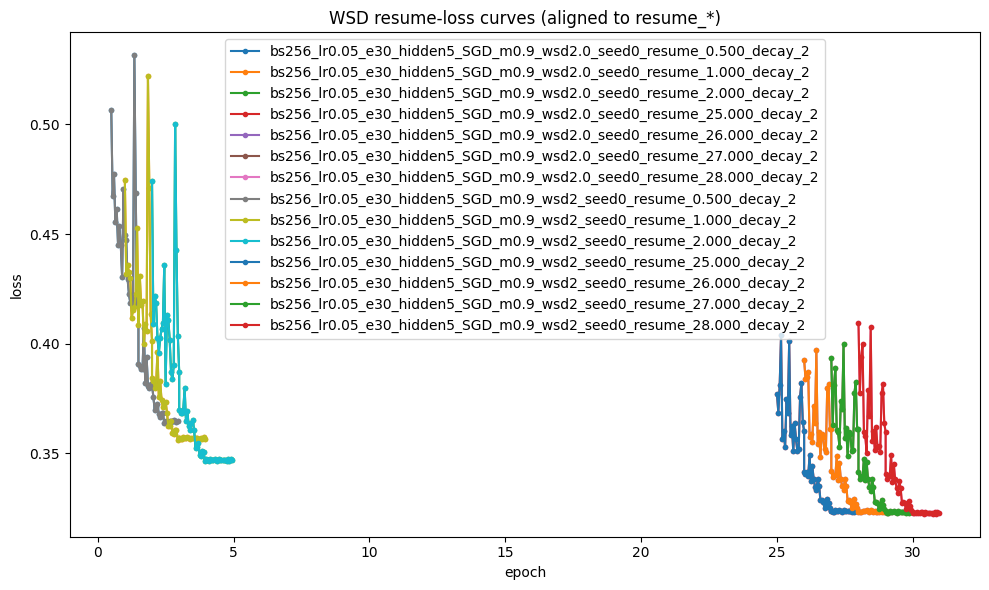

In [2]:
import re, os
from glob import glob
import matplotlib.pyplot as plt
import numpy as np

base_dir = "trained_MLP"
log_paths = sorted(glob(f"{base_dir}/bs*_wsd*_seed*_*resume_*_decay_*/train.log"))

line_pat = re.compile(r"WSD decaying \| epoch=([0-9.]+) \| loss=([0-9.]+) \| acc=([0-9.]+)% \| lr=([0-9.]+)")
resume_pat = re.compile(r"resume_([0-9.]+)_decay_")

def parse_resume_base_from_dir(run_dir: str) -> float:
    m = resume_pat.search(run_dir)
    return float(m.group(1)) if m else float("nan")

plt.figure(figsize=(10, 6))
for lp in log_paths:
    run_dir = os.path.dirname(lp)
    resume_base = parse_resume_base_from_dir(run_dir)

    epochs, losses = [], []
    with open(lp, "r", encoding="utf-8", errors="ignore") as f:
        for line in f:
            m = line_pat.search(line)
            if m:
                epochs.append(float(m.group(1)))
                losses.append(float(m.group(2)))
    if not epochs:
        continue

    epochs = np.array(epochs, dtype=float)
    losses = np.array(losses, dtype=float)

    # 对齐：把该 run 的最小日志 epoch 平移到目录中的 resume 起点
    if np.isfinite(resume_base):
        min_ep = np.nanmin(epochs)
        if np.isfinite(min_ep):
            epochs = epochs + (resume_base - min_ep)

    order = np.argsort(epochs)
    epochs = epochs[order]
    losses = losses[order]

    label = os.path.basename(run_dir)
    plt.plot(epochs, losses, marker=".", label=label)

plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("WSD resume-loss curves (aligned to resume_*)")
plt.legend()
plt.tight_layout()
plt.show()

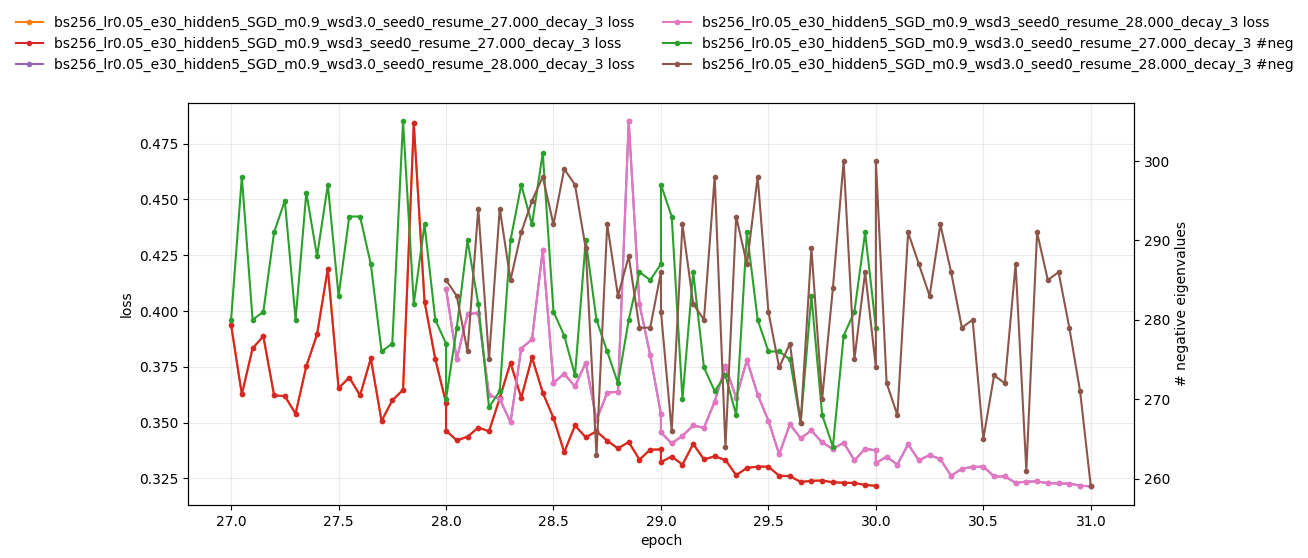

In [13]:
import os, re, torch
from glob import glob
import numpy as np
import matplotlib.pyplot as plt

base_dir = "trained_MLP"
target_resumes = [27.000, 28.000]

line_pat = re.compile(r"WSD decaying \| epoch=([0-9.]+) \| loss=([0-9.]+) \| acc=([0-9.]+)% \| lr=([0-9.]+)")
resume_pat = re.compile(r"resume_([0-9.]+)_decay_")

def parse_resume_base_from_dir(run_dir: str) -> float:
    m = resume_pat.search(run_dir)
    return float(m.group(1)) if m else float("nan")

def align_epochs(epochs: np.ndarray, resume_base: float) -> np.ndarray:
    if epochs.size == 0 or not np.isfinite(resume_base):
        return epochs
    m = np.nanmin(epochs)
    return epochs + (resume_base - m) if np.isfinite(m) else epochs

def load_loss_series(run_dir: str):
    log_path = os.path.join(run_dir, "train.log")
    if not os.path.isfile(log_path):
        return None, None
    epochs, losses = [], []
    with open(log_path, "r", encoding="utf-8", errors="ignore") as f:
        for line in f:
            m = line_pat.search(line)
            if m:
                epochs.append(float(m.group(1)))
                losses.append(float(m.group(2)))
    if not epochs:
        return None, None
    epochs = np.array(epochs, dtype=float)
    losses = np.array(losses, dtype=float)
    resume_base = parse_resume_base_from_dir(run_dir)
    epochs = align_epochs(epochs, resume_base)
    order = np.argsort(epochs)
    return epochs[order], losses[order]

def load_neg_count_curve(run_dir: str):
    npy_path = os.path.join(run_dir, "hessian_results", "hessian_trend.npy")
    if not os.path.isfile(npy_path):
        return None, None
    loaded = np.load(npy_path, allow_pickle=True).tolist()
    results = loaded if isinstance(loaded, list) else list(loaded)

    epochs, neg_counts = [], []
    for r in results:
        ckpt_path = r.get("ckpt")
        if not ckpt_path or not os.path.isfile(ckpt_path):
            continue
        try:
            st = torch.load(ckpt_path, map_location="cpu")
            ep = float(st.get("epoch_progress", np.nan))
        except Exception:
            ep = np.nan
        if not np.isfinite(ep):
            continue
        evals = np.asarray(r["all_evals"])
        neg_counts.append(int((evals < 0).sum()))
        epochs.append(ep)

    if not epochs:
        return None, None
    epochs = np.array(epochs, dtype=float)
    neg_counts = np.array(neg_counts, dtype=int)
    resume_base = parse_resume_base_from_dir(run_dir)
    epochs = align_epochs(epochs, resume_base)
    order = np.argsort(epochs)
    return epochs[order], neg_counts[order]

# 收集两个 run（resume=27 与 28）
run_dirs = []
for r in target_resumes:
    run_dirs.extend(sorted(glob(f"{base_dir}/bs*_wsd*_seed*_*resume_{r:.3f}_decay_*/")))

fig, ax1 = plt.subplots(figsize=(11,5))
ax2 = ax1.twinx()

colors = ["C0", "C1", "C2", "C3", "C4","C5","C6"]
h1, h2 = [], []
c = 0

for i, rd in enumerate(run_dirs):
    name = os.path.basename(os.path.normpath(rd))
    color = colors[i % len(colors)]
    
    ep_loss, loss = load_loss_series(rd)
    if ep_loss is not None:
        c+=1
        h1_line, = ax1.plot(ep_loss, loss, marker=".", color=colors[c % len(colors)], linestyle="-", label=f"{name} loss")
        h1.append(h1_line)

    ep_neg, negcnt = load_neg_count_curve(rd)
    if ep_neg is not None:
        c+=1
        h2_line, = ax2.plot(ep_neg, negcnt, marker=".", color=colors[c % len(colors)], linestyle="-", label=f"{name} #neg")
        h2.append(h2_line)

ax1.set_xlabel("epoch")
ax1.set_ylabel("loss")
ax2.set_ylabel("# negative eigenvalues")

# 合并图例，并放到图外上方，避免遮挡
handles = h1 + h2
labels = [h.get_label() for h in handles]
fig.legend(handles, labels, loc="upper center", bbox_to_anchor=(0.5, 1.12), ncol=2, frameon=False)

ax1.grid(True, alpha=0.25)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()